# 비트코인 예측하기
 ## 시계열 데이터 분석
 - 연속적인 시간에 따라 다르게 측정되는 데이터 > 시계열 데이터

In [4]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_path = 'market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
# Step1. 탐색 : 시간정보가 포함된 데이터 살펴보기
# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())

(366, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     366 non-null    object 
 1   price   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [5]:
bitcoin_df.tail()

,day,price
361,2020-07-17 00:00:00,9131.00
362,2020-07-18 00:00:00,9154.19
363,2020-07-19 00:00:00,9174.71
364,2020-07-20 00:00:00,9214.66
365,2020-07-21 00:00:00,9163.87


In [6]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터 프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2019-07-22,10587.41
2019-07-23,10323.62
2019-07-24,9844.30
2019-07-25,9772.17
2019-07-26,9875.17


In [7]:
bitcoin_df.describe()

,price
count,366.000000
mean,8718.217322
std,1312.569856
min,4830.210000
25%,7637.620000
50%,8911.835000
75%,9623.185000
max,11996.410000


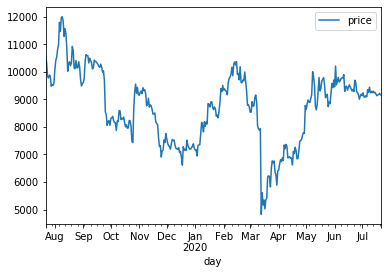

In [8]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

In [9]:
# Step2 예측 : 파이썬 라이브러리를 활용하여 시세 예측하기
# AR 모델 자기 자신의 과거를 정보로 사용하는 개념
# MA 모델 이전항에서 오차를 이용하여 현재항의 상태를 추론하는 방법
# AR 모델+ MA 모델 = ARIMA 모델 + 추세 변동의 경향성
# statsmodel 모듈로 ARIMA분석 수행 가능
# order=(2,1,2) # AR이 몇번째 까지 보는지 / 차이에 대한 파라미터 / MA가 몇번째 까지 보는지
# AR 과 MA를 2로 설정->p-value가 0.05이하-> 유의미한 데이터

In [10]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit=model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2624.153
Method:                       css-mle   S.D. of innovations            320.634
Date:                Mon, 27 Jul 2020   AIC                           5260.306
Time:                        15:14:28   BIC                           5283.706
Sample:                             1   HQIC                          5269.606
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8484     16.403     -0.235      0.815     -35.997      28.301
ar.L1.D.y     -1.8567      0.088    -21.195      0.000      -2.028      -1.685
ar.L2.D.y     -0.9121      0.087    -10.491      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
# ARIMA 분석의 파라미터
# p와 q의 합이 2미만인 경우, 곱이 0을 포함한 짝수인 경우의 파라미터 조합을 사용->가이드라인

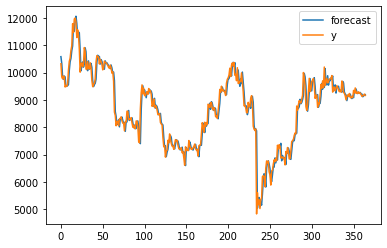

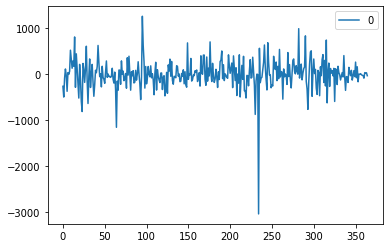

In [12]:
fig=model_fit.plot_predict() #학습데이터에 대한 예측결과
residuals=pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다.
residuals.plot()

In [15]:
# 두번째 그래프는 실제값과 예측값 사이의 오차 변동
# ARIMA 모델 평가 -> 테스트 전용 데이터 ->앞으로 N일동안 어느정도 상승/하락할지 대략적 경향 예측
forecast_data=model_fit.forecast(steps=5) # 학습데이터셋으로부터 5일뒤 예측
test_file_path='market-price-test.csv'
bitcoin_test_df=pd.read_csv(test_file_path, names=['ds','y'])

pred_y=forecast_data[0].tolist() # 마지막 5일의 예측 데이터 7/17~7/21
test_y=bitcoin_test_df.y.values #실제 5일 가격 데이터 <= 18/8/27~18/8/21 ====여기에 데이터 업데이트 하면 됨
pred_y_lower= [] # 마지막 5일의 예측 데이터 최소값
pred_y_upper=[] # 마지막 5일의 예측 데이터 최댓값
for lower_upper in forecast_data[2]:
    lower=lower_upper[0]
    upper=lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

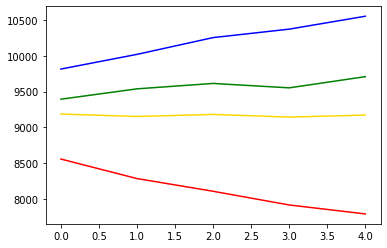

In [16]:
plt.plot(pred_y,color="gold") # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예측한 최저 가격
plt.plot(pred_y_upper, color="blue") # 모델이 예측한 최고 가격
plt.plot(test_y, color="green") # 실제 가격 그래프 -> test_y 기반
plt.legend(['예측 가격','초',])


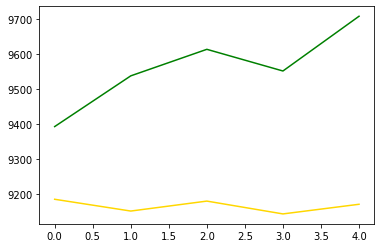

In [17]:
plt.plot(pred_y, color="gold") #모델이 예상한 가격 그래프
plt.plot(test_y,color="green") # 실제 가격 그래프